# A02 - Fitting

#### I.P.D.D.Rajapaksha                                                            
#### 210503H



###  Image Loading and Preprocessing

In [117]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load and convert the image to grayscale."""
    image = cv.imread(image_path, cv.IMREAD_REDUCED_COLOR_4)
    grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return grayscale_image

# Load the grayscale sunflower field image
grayscale_img = load_image('the_berry_farms_sunflower_field.jpeg')



### Gaussian-Laplacian Transformation

In [118]:
def apply_gaussian_laplacian(image, sigma_value):
    """Apply Gaussian Blur followed by Laplacian filtering."""
    blurred = cv.GaussianBlur(image, (0, 0), sigma_value)
    laplacian = cv.Laplacian(blurred, cv.CV_64F)
    return np.abs(laplacian)


###  Blob Detection Across Multiple Scales

In [119]:
def detect_blobs(image, min_scale, max_scale, num_scales, threshold):
    """Detect blobs across multiple scales and return the detected blobs."""
    scales = np.linspace(min_scale, max_scale, num_scales)
    blobs = []

    for scale in scales:
        adjusted_scale = scale / np.sqrt(2)
        print(f"Processing scale: {adjusted_scale}")

        # Apply Gaussian-Laplacian transformation
        laplacian_image = apply_gaussian_laplacian(image, adjusted_scale)

        # Create a binary mask based on the threshold
        binary_mask = laplacian_image > threshold * laplacian_image.max()

        # Detect contours in the binary mask
        contours, _ = cv.findContours(binary_mask.astype(np.uint8), 
                                      cv.RETR_EXTERNAL, 
                                      cv.CHAIN_APPROX_SIMPLE)

        # Extract circles from contours
        for contour in contours:
            if len(contour) >= 5:
                (x, y), radius = cv.minEnclosingCircle(contour)
                blobs.append(((int(x), int(y)), int(radius), adjusted_scale))

    return sorted(blobs, key=lambda b: -b[1])  # Sort by radius (largest first)

# Blob detection parameters
min_sigma = 1.0
max_sigma = 4.0
scale_count = 8
detection_threshold = 0.3

# Detect blobs
detected_blobs = detect_blobs(grayscale_img, min_sigma, max_sigma, 
                              scale_count, detection_threshold)


Processing scale: 0.7071067811865475
Processing scale: 1.0101525445522106
Processing scale: 1.313198307917874
Processing scale: 1.616244071283537
Processing scale: 1.9192898346492004
Processing scale: 2.2223355980148636
Processing scale: 2.5253813613805267
Processing scale: 2.82842712474619


###  Display Results and Plot the Blobs

Largest Blob Parameters:
Center: (216, 166)
Radius: 29
Scale: 1.9192898346492004


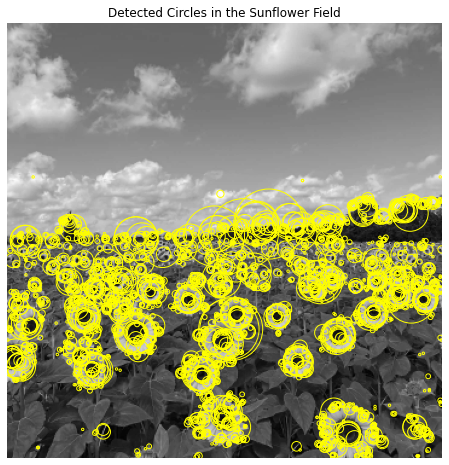

In [120]:
def plot_blobs(image, blobs):
    """Plot the detected blobs on the grayscale image."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image, cmap='gray')

    for (center, radius, _) in blobs:
        circle = plt.Circle(center, radius, color='yellow', fill=False, linewidth=1)
        ax.add_patch(circle)

    plt.axis('off')
    plt.title('Detected Circles in the Sunflower Field')
    plt.show()

# Display the largest detected blob
if detected_blobs:
    largest_blob = detected_blobs[0]
    print("Largest Blob Parameters:")
    print(f"Center: {largest_blob[0]}")
    print(f"Radius: {largest_blob[1]}")
    print(f"Scale: {largest_blob[2]}")

# Plot all detected blobs on the image
plot_blobs(grayscale_img, detected_blobs)


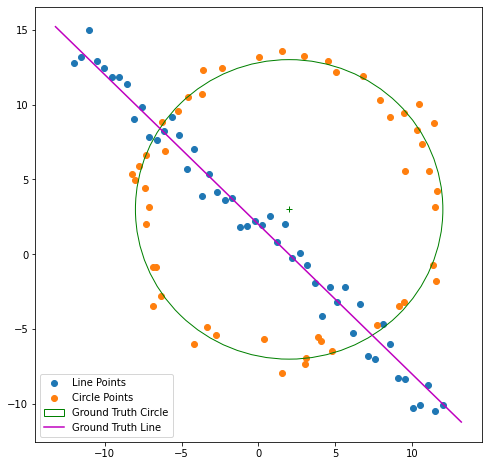

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points
N = 100
half_n = N // 2

# Circle parameters
r = 10  # Radius
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16  # Noise scale for circle points

# Generate circle points
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Noise
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Line parameters
s = 1.0  # Noise scale for line points
m, b = -1, 2  # Line equation: y = mx + b

# Generate line points
x = np.linspace(-12, 12, half_n)  # X-coordinates for the line
y = m * x + b + s * np.random.randn(half_n)  # Y-coordinates with noise
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine all points
X = np.vstack((X_circ, X_line))  # All points (circle + line)

# Plot the generated points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line Points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle Points')

# Plot ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')  # Plot circle center

# Plot ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground Truth Line')

# Display legend and plot
plt.legend()
plt.show()


### Line Equation and Consensus

In [135]:
import math
import numpy as np

# Defining dataset and number of points
num_points = X.shape[0]
data_points = X

def calculate_line_equation(point1_x, point1_y, point2_x, point2_y):
    """Calculate line equation coefficients from two points."""
    delta_x = point2_x - point1_x
    delta_y = point2_y - point1_y
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    coeff_a = delta_y / magnitude
    coeff_b = -delta_x / magnitude
    intercept = (coeff_a * point1_x) + (coeff_b * point1_y)
    return coeff_a, coeff_b, intercept

def total_least_squares_error(coefficients, selected_indices):
    """Calculate total least squares error for a line model."""
    coeff_a, coeff_b, intercept = coefficients
    return np.sum(np.square(coeff_a * data_points[selected_indices, 0] + 
                             coeff_b * data_points[selected_indices, 1] - intercept))

def constraint_function(coefficients):
    """Define constraint for coefficients."""
    return coefficients[0]**2 + coefficients[1]**2 - 1

constraints = ({'type': 'eq', 'fun': constraint_function})

def identify_inliers(data, coefficients, threshold):
    """Identify inliers based on the consensus function."""
    coeff_a, coeff_b, intercept = coefficients
    error = np.absolute(coeff_a * data[:, 0] + coeff_b * data[:, 1] - intercept)
    return error < threshold


### RANSAC Line Fitting

Optimal line model: [0.72402112 0.68977781 1.19831598]
(100, 2)


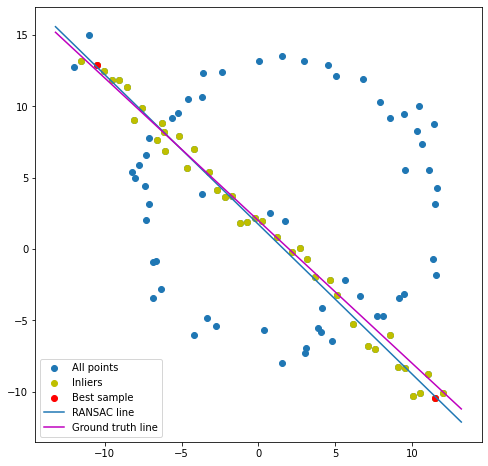

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parameters
threshold = 1        # Threshold for inlier detection
min_inliers_count = 0.4 * num_points  # Minimum number of close points to confirm model fit
min_points_required = 2  # Minimum points needed to estimate model parameters

line_inliers_indices = []  # Indices of identified inliers
max_iterations = 50
iteration_count = 0
optimal_line_model = []  # Optimal model parameters (a, b, d)
lowest_error = np.inf 
sample_indices_for_best_model = []  # Indices leading to best model estimation
model_result_from_best_sample = []  # Model result from best sample
best_inliers_for_model = []  # Inliers associated with the best model

while iteration_count < max_iterations:
    sample_indices = np.random.randint(0, num_points, min_points_required)  # Randomly select sample points
    initial_guess = np.array([1, 1, 0])  # Initial parameter estimate
    optimization_result = minimize(fun=total_least_squares_error, args=(sample_indices,), 
                                   x0=initial_guess, tol=1e-6, constraints=constraints, 
                                   options={'disp': False})
    
    # Identify inliers for the current model
    line_inliers_indices = identify_inliers(data_points, optimization_result.x, threshold)
    
    # Check if the current model is sufficient (enough inliers)
    if line_inliers_indices.sum() > min_inliers_count:
        initial_guess = optimization_result.x
        optimization_result = minimize(fun=total_least_squares_error, 
                                       args=(line_inliers_indices,), 
                                       x0=initial_guess, tol=1e-6, 
                                       constraints=constraints, 
                                       options={'disp': False})
        
        if optimization_result.fun < lowest_error:
            optimal_line_model = optimization_result.x
            lowest_error = optimization_result.fun
            sample_indices_for_best_model = data_points[sample_indices, :]  # Update best sample
            model_result_from_best_sample = initial_guess
            best_inliers_for_model = line_inliers_indices  # Update best inliers
    
    iteration_count += 1

print('Optimal line model:', optimal_line_model)

# Visualization
print(data_points.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(data_points[:, 0], data_points[:, 1], label='All points')

# Plot inliers
ax.scatter(data_points[best_inliers_for_model, 0], data_points[best_inliers_for_model, 1], 
           color='y', label='Inliers')

# Plot best sample points
ax.scatter(sample_indices_for_best_model[:, 0], sample_indices_for_best_model[:, 1], 
           color='r', label='Best sample')

# Plot the line model
x_min_val, x_max_val = ax.get_xlim()
x_values = np.array([x_min_val, x_max_val])
y_values = (-optimal_line_model[0] * x_values + optimal_line_model[2]) / optimal_line_model[1]  # Line equation
plt.plot(x_values, y_values, label='RANSAC line')

# Plot ground truth line (assuming m and b are defined)
y_values_truth = m * x_values + b
plt.plot(x_values, y_values_truth, color='m', label='Ground truth line')

plt.legend()
plt.show()


### Circle Fitting Using RANSAC

(59, 2)


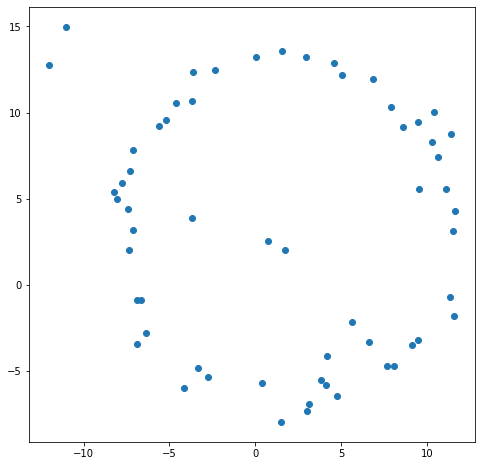

In [137]:
from scipy import optimize
import random

# Extract outliers (points that are not inliers)
outlier_indices = np.where(np.logical_not(best_inliers_for_model))[0]
outlier_data_points = data_points[outlier_indices, :]
print(outlier_data_points.shape)

# Plotting outliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(outlier_data_points[:, 0], outlier_data_points[:, 1], label='Outlier Points')

num_outliers = outlier_data_points.shape[0]

def compute_circle_from_points(points):
    """ Calculate the center and radius of the circle from three points """
    point1, point2, point3 = points[0], points[1], points[2]
    temp = point2[0] ** 2 + point2[1] ** 2
    half_bc = (point1[0] ** 2 + point1[1] ** 2 - temp) / 2
    half_cd = (temp - point3[0] ** 2 - point3[1] ** 2) / 2
    determinant = (point1[0] - point2[0]) * (point2[1] - point3[1]) - (point2[0] - point3[0]) * (point1[1] - point2[1])

    # Center of the circle
    center_x = (half_bc * (point2[1] - point3[1]) - half_cd * (point1[1] - point2[1])) / determinant
    center_y = ((point1[0] - point2[0]) * half_cd - (point2[0] - point3[0]) * half_bc) / determinant

    radius = np.sqrt((center_x - point1[0]) ** 2 + (center_y - point1[1]) ** 2)
    return ((center_x, center_y), radius)

def identify_circle_inliers(points_list, center, radius):
    """ Identify inliers to a circle model based on a threshold """
    inliers = []
    threshold = radius / 3  # Set threshold to one-third of the radius

    for point in points_list:
        distance_error = np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2) - radius
        if distance_error < threshold:
            inliers.append(point)

    return np.array(inliers)

def get_random_sample(points_list):
    """ Get a list of three random points from a given list """
    sample_indices = random.sample(range(len(points_list)), 3)
    return np.array([points_list[i] for i in sample_indices])

def calculate_distance_from_center(x_values, y_values, center_x, center_y):
    """ Calculate the distance of each 2D point from the circle's center """
    return np.sqrt((x_values - center_x) ** 2 + (y_values - center_y) ** 2)

def algebraic_distance(center, x_values, y_values):
    """ Calculate the algebraic distance between points and the mean circle centered at the given center """
    distances = calculate_distance_from_center(x_values, y_values, *center)
    return distances - distances.mean()

def fit_circle_via_least_squares(x_mean, y_mean, points):
    """ Fit a circle using least squares optimization """
    x_coordinates = points[:, 0]
    y_coordinates = points[:, 1]
    initial_center = x_mean, y_mean
    estimated_center, _ = optimize.leastsq(algebraic_distance, initial_center, (x_coordinates, y_coordinates))

    center_x, center_y = estimated_center
    mean_radius = calculate_distance_from_center(x_coordinates, y_coordinates, *estimated_center).mean()

    return (center_x, center_y), mean_radius


### RANSAC Circle Fitting Function

Optimal Circle Center: (-5.1878467249505125, 6.0675879099855745)
Optimal Circle Radius: 15.068651496082621
(59, 2)
Inliers Found: [[ 11.5480358   -1.81401492]
 [ -7.11681268   3.16261404]
 [ 11.12586966   5.55277205]
 [  4.76756032  -6.42545882]
 [ 11.51352004   3.14185912]
 [  1.54384358  13.56156757]
 [ -2.37112304  12.44414609]
 [ 10.29941699   8.27238241]
 [ 10.61094589   7.39335352]
 [ -7.38453035   4.43013833]
 [ -6.35876879  -2.79662585]
 [  6.82913887  11.93935993]
 [  2.96849492  13.217907  ]
 [ 11.35428009  -0.71200717]
 [ -4.17764746  -6.00543896]
 [  7.92726997  10.33219642]
 [ -6.88868623  -0.86891869]
 [ -3.70141804  10.69477126]
 [  3.85341702  -5.49558935]
 [ 11.40831793   8.74257777]
 [ -8.04192964   4.96762281]
 [  4.0882314   -5.80753872]
 [ -7.34069644   2.04347708]
 [  3.01405573  -7.30175799]
 [ -3.60237275  12.32821941]
 [  0.36319544  -5.68277684]
 [ -4.59252552  10.52977583]
 [ -3.33651434  -4.83706434]
 [  0.04127444  13.20899176]
 [  8.57863745   9.16899169]


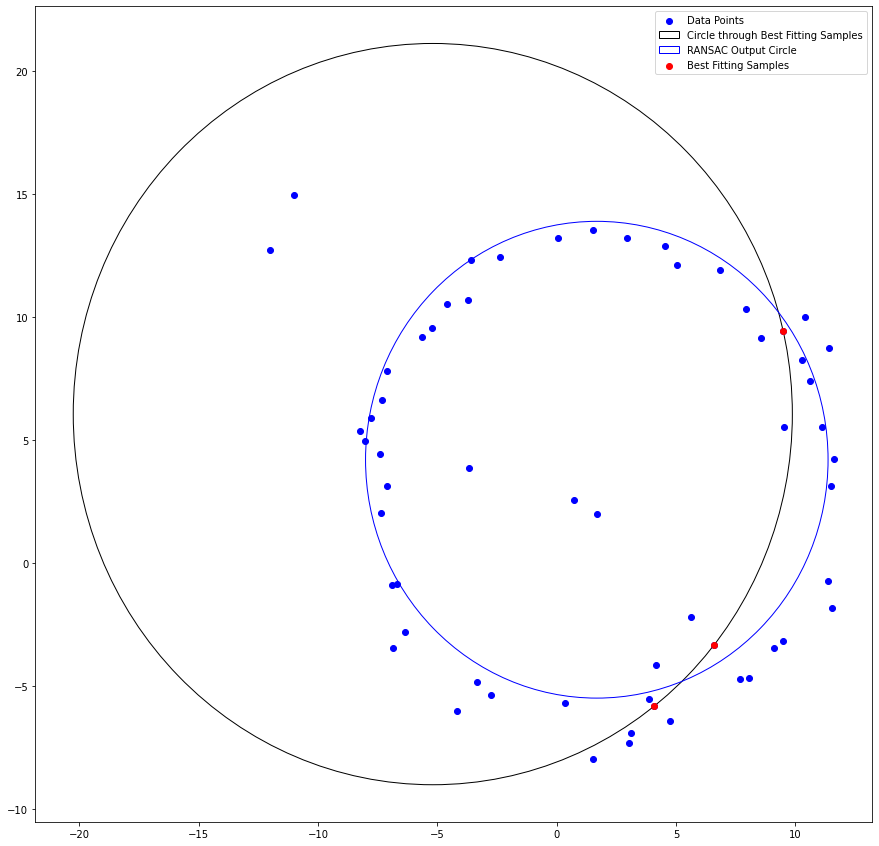

In [138]:
def fit_circle_with_ransac(point_cloud, iterations):
    """ Fit a circle to a set of points using the RANSAC algorithm. 
        Returns the center, radius, best sample points, and their inliers.
    """
    optimal_sample = []
    optimal_circle_center = (0, 0)
    optimal_circle_radius = 0
    optimal_inliers = []
    max_inlier_count = 20
    
    for _ in range(iterations):
        sample_points = get_random_sample(point_cloud)  # Generate a random sample of 3 points
        circle_center, circle_radius = compute_circle_from_points(sample_points)  # Calculate the circle's center and radius
        inlier_points = identify_circle_inliers(point_cloud, circle_center, circle_radius)  # Get inliers
        inlier_count = len(inlier_points)

        # Update best approximation if current sample has more inliers
        if inlier_count > max_inlier_count:
            optimal_sample = sample_points
            max_inlier_count = inlier_count
            optimal_circle_center = circle_center
            optimal_circle_radius = circle_radius
            optimal_inliers = inlier_points

    print("Optimal Circle Center:", optimal_circle_center)
    print("Optimal Circle Radius:", optimal_circle_radius)

    return optimal_circle_center, optimal_circle_radius, optimal_sample, optimal_inliers

# Calculating the RANSAC outputs for the outlier dataset
optimal_center, optimal_radius, best_samples, inlier_points = fit_circle_with_ransac(outlier_data_points, 50000)
print(outlier_data_points.shape)
print("Inliers Found:", inlier_points)

# Plotting results
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.scatter(outlier_data_points[:, 0], outlier_data_points[:, 1], color='blue', label="Data Points")

# Plotting the circle created by the best fitting points
circle = plt.Circle(optimal_center, optimal_radius, fill=False, label="Circle through Best Fitting Samples", color='k')
ax.add_patch(circle)

# Plotting inliers
print("Ratio of Inliers =", len(inlier_points) / num_outliers * 100, "%")

# Estimate the circle using inliers with least squares method
ransac_circle_center, ransac_circle_radius = fit_circle_via_least_squares(optimal_center[0], optimal_center[1], inlier_points)
print("RANSAC Circle Center:", ransac_circle_center)
print("RANSAC Circle Radius:", ransac_circle_radius)
ransac_circle = plt.Circle(ransac_circle_center, ransac_circle_radius, fill=False, label="RANSAC Output Circle", color='b')
ax.add_patch(ransac_circle)

# Plotting the best fitting samples
ax.scatter(best_samples[:, 0], best_samples[:, 1], color='red', label="Best Fitting Samples")
ax.legend()


### Revised Plotting Code

Ratio of Inliers = 89.47368421052632 %
Center of RANSAC Circle = (2.0435741271449093, 3.870549248953072)
Radius of RANSAC Circle = 9.432686503699676


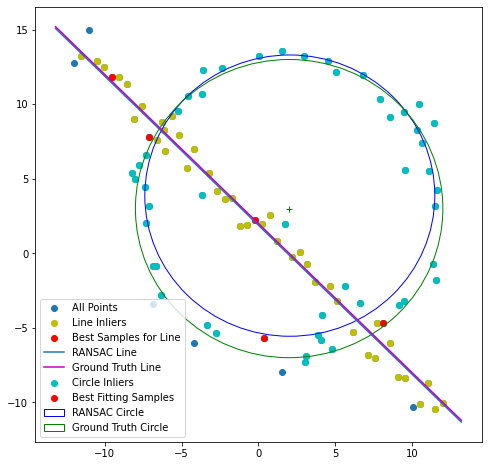

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot of all points
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points')

# Scatter plot for inliers of the line model
ax.scatter(dataset[best_inliers_line, 0], dataset[best_inliers_line, 1], color='y', label='Line Inliers')

# Scatter plot for the best sample points of the line model
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], color='r', label='Best Samples for Line')

# Calculate and plot the RANSAC line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1] * x_ + best_model_line[2]) / best_model_line[1]  # Line equation
plt.plot(x_, y_, label='RANSAC Line')

# Plot the ground truth line
y_ground_truth = m * x_ + b
plt.plot(x_, y_ground_truth, color='m', label='Ground Truth Line')

# Plotting the inliers for the circle model
print("Ratio of Inliers =", len(inliers) / len(outliers_data) * 100, "%")
ax.scatter(inliers[:, 0], inliers[:, 1], color='c', label="Circle Inliers")

# Scatter plot for the best fitting samples used to estimate the circle
ax.scatter(sample[:, 0], sample[:, 1], color='red', label="Best Fitting Samples")

# Plotting the RANSAC circle using estimated parameters
print("Center of RANSAC Circle =", ransac_center)
print("Radius of RANSAC Circle =", ransac_radius)
ransac_circle = plt.Circle(ransac_center, ransac_radius, fill=False, label="RANSAC Circle", color='b')
ax.add_patch(ransac_circle)

# Plotting the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Show legends and plot
ax.legend()
plt.show()


Circle Fitting on Linear Data:

If the data contains points that predominantly follow a linear pattern (like a line with some noise or outliers), fitting a circle first may lead to poor results. The circle will try to capture all points, even those that are aligned along the line, resulting in a large radius and poorly positioned center.
The circle model might treat line points as noise, incorrectly trying to encompass them into the circular fit.
Misidentification of Inliers:

When fitting a circle first, many points that should belong to the line may be misidentified as outliers, because they won’t fit the circular model. This will lead to a low ratio of inliers, weakening the overall RANSAC performance.
Order of Model Complexity:

A circle is a more complex geometric shape than a line, requiring three parameters (center coordinates and radius) compared to the two needed for a line (slope and intercept). If you fit the circle first, you risk overfitting or incorrectly modeling simpler structures like a line, which could reduce the effectiveness of RANSAC.

## Queston 3

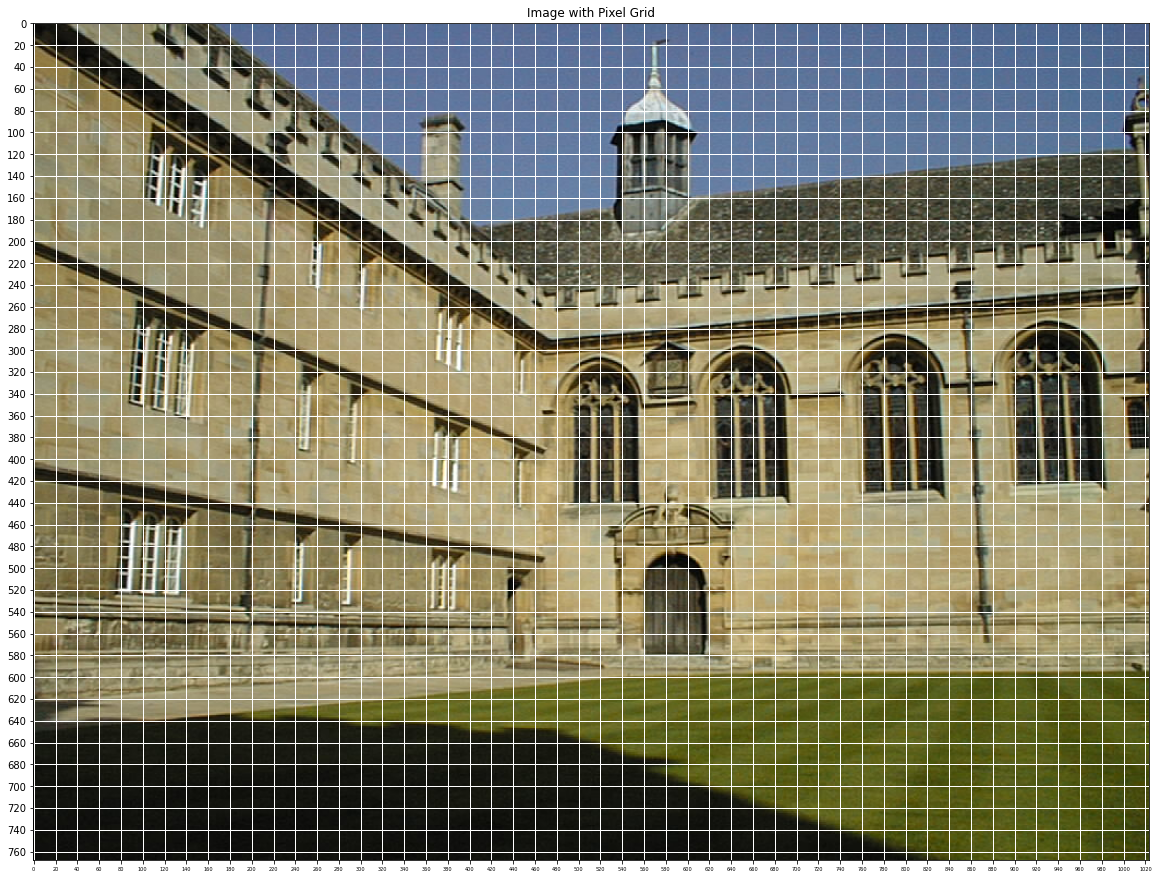

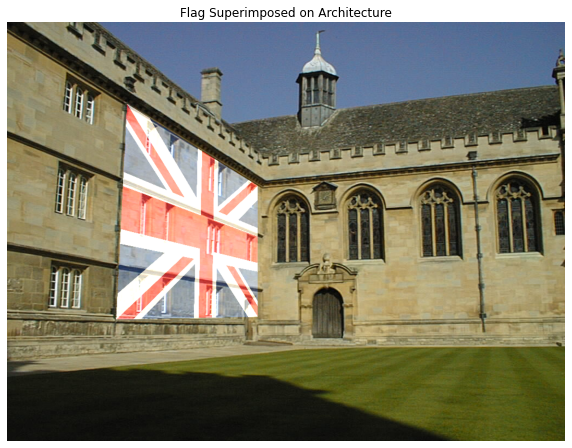

array([[[ 12,  14,  14],
        [ 11,  13,  13],
        [ 10,  12,  12],
        ...,
        [140,  98,  75],
        [141,  99,  76],
        [142, 100,  77]],

       [[ 12,  14,  14],
        [ 11,  13,  13],
        [ 10,  12,  12],
        ...,
        [137,  95,  72],
        [137,  95,  72],
        [137,  95,  72]],

       [[ 11,  13,  13],
        [ 10,  12,  12],
        [  9,  11,  11],
        ...,
        [136,  94,  71],
        [136,  94,  71],
        [136,  94,  71]],

       ...,

       [[ 13,  15,  15],
        [ 12,  14,  14],
        [ 11,  13,  13],
        ...,
        [ 13,  68,  59],
        [ 13,  69,  58],
        [ 14,  70,  59]],

       [[ 12,  14,  14],
        [ 11,  13,  13],
        [ 11,  13,  13],
        ...,
        [ 19,  76,  67],
        [ 15,  75,  64],
        [ 13,  73,  62]],

       [[ 12,  14,  14],
        [ 11,  13,  13],
        [ 11,  13,  13],
        ...,
        [ 25,  82,  73],
        [ 19,  79,  68],
        [ 15,  75,  64]]

In [154]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load and display an image with grid overlay
def display_image_with_grid(image_path, grid_size=20):
    image = cv2.imread(image_path)
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks(np.arange(0, image.shape[1], grid_size), fontsize=5)
    plt.yticks(np.arange(0, image.shape[0], grid_size))
    plt.grid(True, color='white', linewidth=1)
    plt.title('Image with Pixel Grid')
    plt.show()
    return image

# Function to compute the homography and warp the flag image onto the architectural image
def warp_flag_onto_image(architecture_img, flag_img, architecture_points, flag_points):
    # Compute the homography matrix
    homography_matrix, _ = cv2.findHomography(flag_points, architecture_points)
    
    # Warp the flag image to match the architecture image
    warped_flag = cv2.warpPerspective(flag_img, homography_matrix, (architecture_img.shape[1], architecture_img.shape[0]))
    
    return warped_flag

# Function to blend the warped flag and architectural image
def blend_images(architecture_img, warped_flag, alpha=0.7):
    # Blend the two images
    blended_image = cv2.addWeighted(architecture_img, 1, warped_flag, alpha, 0)
    return blended_image

# Function to handle the entire process for a pair of images
def superimpose_flag_on_architecture(architecture_img_path, flag_img_path, architecture_points, alpha=0.7):
    # Load images
    architecture_img = display_image_with_grid(architecture_img_path)
    flag_img = cv2.imread(flag_img_path)

    # Define the flag's corner points in its own image coordinates
    flag_points = np.array([[0, 0], [flag_img.shape[1], 0], [flag_img.shape[1], flag_img.shape[0]], [0, flag_img.shape[0]]], dtype=np.float32)
    
    # Warp the flag onto the architectural image
    warped_flag = warp_flag_onto_image(architecture_img, flag_img, architecture_points, flag_points)

    # Blend the images
    result_img = blend_images(architecture_img, warped_flag, alpha)
    
    # Display the final result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title('Flag Superimposed on Architecture')
    plt.axis('off')
    plt.show()

    return result_img

# Example usage with different image pairs and points
# Architectural image and flag example 1
architecture_img_path_1 = '005.jpg'
flag_img_path_1 = 'flag.png'
architecture_points_1 = np.array([[220, 150], [460, 300], [460, 540], [200, 545]], dtype=np.float32)

superimpose_flag_on_architecture(architecture_img_path_1, flag_img_path_1, architecture_points_1)



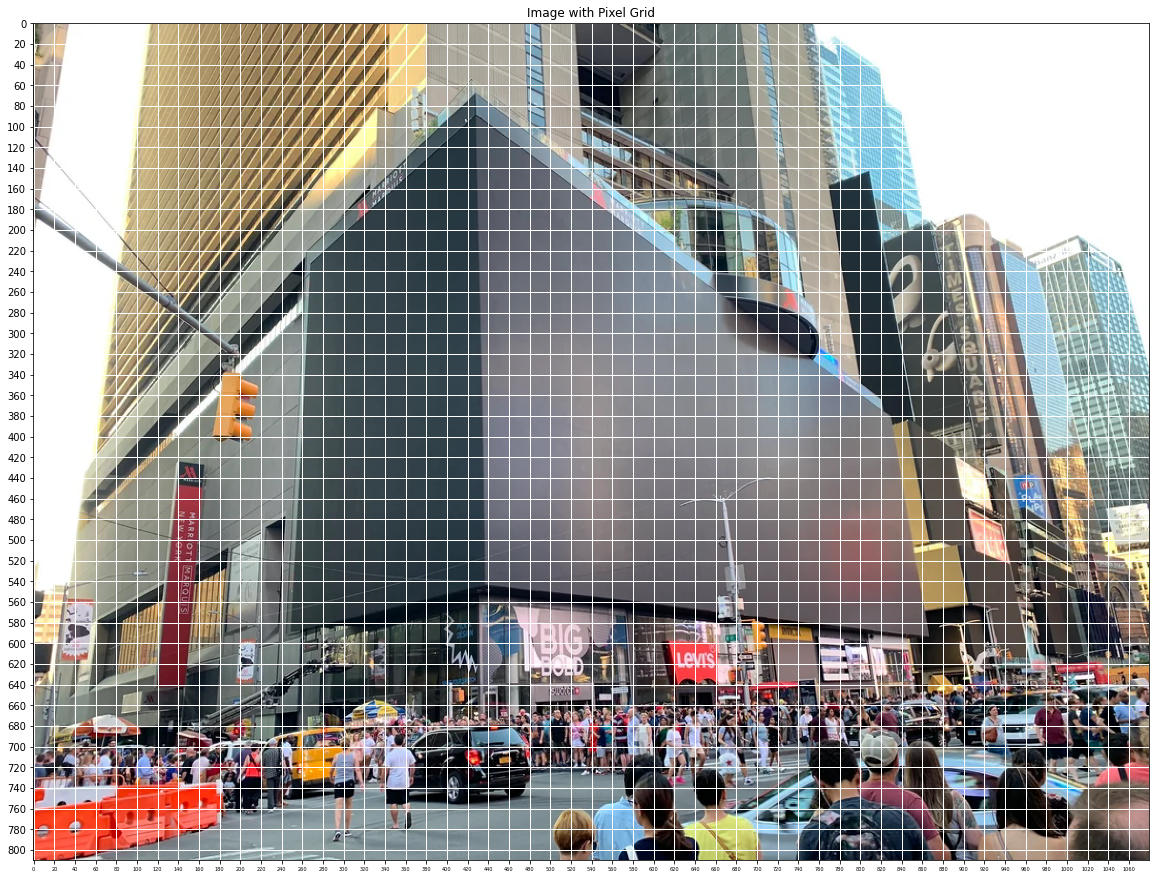

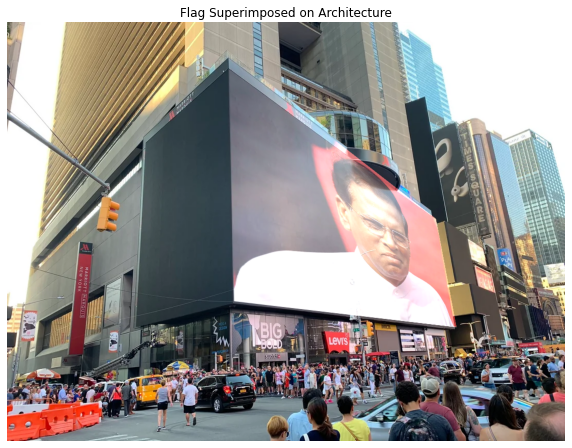

array([[[ 92, 115, 109],
        [ 85, 107, 104],
        [ 65,  85,  84],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 97, 120, 114],
        [ 96, 118, 114],
        [ 60,  81,  80],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 92, 115, 109],
        [ 95, 116, 113],
        [ 68,  89,  88],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 59,  81, 251],
        [ 61,  82, 249],
        [ 63,  83, 246],
        ...,
        [ 62,  67,  78],
        [ 61,  66,  77],
        [ 61,  66,  77]],

       [[ 50,  73, 247],
        [ 54,  77, 246],
        [ 58,  81, 243],
        ...,
        [ 64,  68,  76],
        [ 64,  68,  76],
        [ 63,  67,  75]],

       [[ 48,  73, 248],
        [ 52,  76, 247],
        [ 58,  81, 243],
        ...,
        [ 64,  68,  76],
        [ 64,  68,  76],
        [ 63,  67,  75]]

In [170]:
architecture_img_path_2 = 'z0rfdwjxw5a31.jpg'
flag_img_path_2 = 'my3.png'
architecture_points_2 = np.array([[430, 70], [830, 380], [870, 590], [440, 540]], dtype=np.float32)

superimpose_flag_on_architecture(architecture_img_path_2, flag_img_path_2, architecture_points_2)

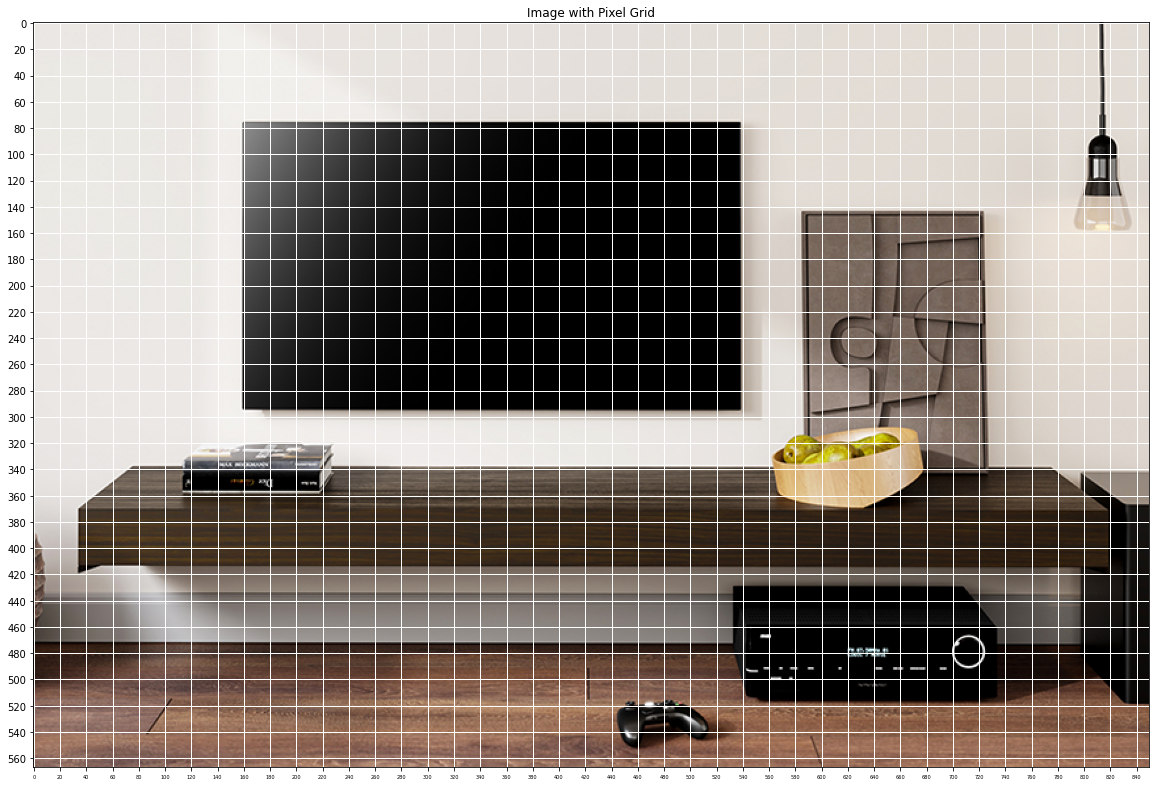

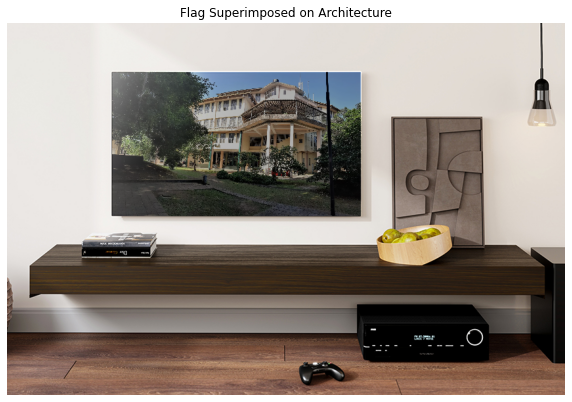

array([[[227, 232, 235],
        [227, 232, 235],
        [227, 232, 235],
        ...,
        [213, 221, 228],
        [214, 220, 227],
        [211, 221, 228]],

       [[227, 232, 235],
        [228, 233, 236],
        [229, 234, 237],
        ...,
        [213, 221, 228],
        [215, 221, 228],
        [213, 221, 228]],

       [[227, 232, 235],
        [227, 232, 235],
        [228, 233, 236],
        ...,
        [213, 221, 228],
        [214, 220, 227],
        [213, 221, 228]],

       ...,

       [[ 98, 110, 144],
        [100, 110, 144],
        [ 95, 104, 138],
        ...,
        [ 79,  96, 139],
        [ 80, 100, 141],
        [ 84, 105, 150]],

       [[ 92, 102, 136],
        [ 98, 108, 142],
        [ 91, 102, 134],
        ...,
        [ 83, 106, 151],
        [ 86, 108, 150],
        [ 84, 107, 152]],

       [[100, 108, 145],
        [ 96, 106, 140],
        [ 84,  94, 128],
        ...,
        [ 83, 108, 152],
        [ 85, 108, 154],
        [ 83, 106, 151]]

In [191]:
architecture_img_path_2 = 'tv.jpg'
flag_img_path_2 = 'entc.webp'
architecture_points_2 = np.array([ [160, 75], [540, 75], [540, 295], [160, 295]], dtype=np.float32)

superimpose_flag_on_architecture(architecture_img_path_2, flag_img_path_2, architecture_points_2)

## Question 04
